In [2]:
import json
import albumentations as albu
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
from copy import deepcopy

In [3]:

xmin, ymin, xmax, ymax = [165, 264, 253, 372]
bbox = [[xmin, ymin, xmax, ymax, 'chair']]

trans_hflip = albu.Compose([albu.HorizontalFlip(p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_vflip = albu.Compose([albu.VerticalFlip(p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_gray = albu.Compose([albu.ToGray(p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot45 = albu.Compose([albu.Rotate(limit=(45,45),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot90 = albu.Compose([albu.Rotate(limit=(90,90),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot135 = albu.Compose([albu.Rotate(limit=(135,135),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot180 = albu.Compose([albu.Rotate(limit=(180,180),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot225 = albu.Compose([albu.Rotate(limit=(225,225),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot270 = albu.Compose([albu.Rotate(limit=(270,270),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_rot315 = albu.Compose([albu.Rotate(limit=(315,315),p=1)], bbox_params=albu.BboxParams(format='pascal_voc'))
trans_battery_list = [trans_hflip,trans_vflip,trans_gray,trans_rot45,trans_rot90,trans_rot135,trans_rot180,trans_rot225,trans_rot270,trans_rot315]
trans_list = [trans_hflip,trans_vflip,trans_gray]

In [4]:
with open("/opt/ml/detection/dataset/train.json", "r") as json_file:
    train_json = json.load(json_file)

img_dataset = []


for i in range(4883):
    name_space = str(10000+i)
    dir=f'/opt/ml/detection/dataset/train/{name_space[1:]}.jpg'
    tmp_img = Image.open(dir)
    img_dataset.append(np.array(tmp_img))


In [5]:
objects_df = {'General trash':np.zeros(4883), 'Paper':np.zeros(4883), 'Paper pack':np.zeros(4883), 'Metal':np.zeros(4883), 'Glass':np.zeros(4883),
 'Plastic':np.zeros(4883), 'Styrofoam':np.zeros(4883), 'Plastic bag':np.zeros(4883), 'Battery':np.zeros(4883), 'Clothing':np.zeros(4883)}
objects_df = pd.DataFrame(objects_df)
objects_df = objects_df.astype('int')
class_names = []
for class_dict in train_json['categories']:
    class_names.append(class_dict['name'])

for image_object in train_json['annotations']:
    index = image_object['image_id']
    ctg = class_names[image_object['category_id']]
    objects_df[ctg].loc[index] += 1
print(objects_df.head())

   General trash  Paper  Paper pack  Metal  Glass  Plastic  Styrofoam  \
0              1      0           0      0      0        0          0   
1              2      0           0      1      1        2          0   
2              0      0           0      1      0        0          0   
3              0      0           1      0      0        0          1   
4              1      5           0      0      0        0          0   

   Plastic bag  Battery  Clothing  
0            0        0         0  
1            2        0         0  
2            0        0         0  
3            0        0         0  
4            0        0         0  


In [16]:
aug_json = deepcopy(train_json)
train_json['annotations'][0]

{'image_id': 0,
 'category_id': 0,
 'area': 257301.66,
 'bbox': [197.6, 193.7, 547.8, 469.7],
 'iscrowd': 0,
 'id': 0}

In [6]:
aug_list=[]
aug_imgs = []
init_id = 23143
init_img = 4882
name_num = 10000
check_id = 0
n=0
for index, data in objects_df.iterrows():
    n+=1
    img = img_dataset[index]
    bboxes = []
    for i,d in enumerate(train_json['annotations'][check_id:]):
        if d['image_id']>index:
            break
        check_id +=1
        x1,y1,x2,y2 = d['bbox'][0],d['bbox'][1],d['bbox'][0]+d['bbox'][2],d['bbox'][1]+d['bbox'][3]
        bboxes.append([x1,y1,x2,y2,d['category_id']])

    
    if data['Battery']>0:
        for trans in trans_battery_list:
            init_img+=1
            transformed = trans(image=img,bboxes=bboxes)
            trans_img,trans_bboxes = transformed['image'],transformed['bboxes']
            aug_imgs.append(trans_img)
            for trans_bbox in trans_bboxes:
                x1,y1,x2,y2,label = trans_bbox
                w,h = x2-x1,y2-y1
                init_id+=1
                tmp_data = {
                "image_id": init_img,
                "category_id": label,
                "area": w*h,
                "bbox": [x1,y1,w,h],
                "iscrowd": 0,
                "id": init_id
                }
                aug_list.append(tmp_data)
        continue
            # fig,ax=plt.subplots(1,1,figsize=(5,5))
            # plt.imshow(trans_img)
            # test_b = patches.Rectangle((x1, y1),w,h,linewidth=2,edgecolor = 'green',fill=False)
            # ax.add_patch(test_b)
            # plt.show()

    if (data['Clothing']>0 or data['General trash']>0 ) and data['Paper']==0:
        for trans in trans_list:
            init_img+=1
            transformed = trans(image=img,bboxes=bboxes)
            trans_img,trans_bboxes = transformed['image'],transformed['bboxes']
            aug_imgs.append(trans_img)
            for trans_bbox in trans_bboxes:
                x1,y1,x2,y2,label = trans_bbox
                w,h = x2-x1,y2-y1
                init_id+=1
                tmp_data = {
                "image_id": init_img,
                "category_id": label,
                "area": w*h,
                "bbox": [x1,y1,w,h],
                "iscrowd": 0,
                "id": init_id
                }
                aug_list.append(tmp_data)
        

In [8]:
init_img

9500

In [17]:
aug_json['annotations']+= deepcopy(aug_list)

In [18]:
with open('/opt/ml/detection/dataset/train_aug.json', 'w') as outfile:
    json.dump(aug_json, outfile)
len(aug_json['annotations'])

39710

In [51]:
len(aug_imgs)

4618

In [19]:
import os
 
def createFolder(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
createFolder('/opt/ml/detection/dataset/train_aug')

In [24]:
for i in range(4883):
    name_space = str(10000+i)
    im = Image.fromarray(img_dataset[i])
    im.save(f'/opt/ml/detection/dataset/train_aug/{name_space[1:]}.jpg')

In [25]:
for i in range(4618):
    name_space = str(14883+i)
    im = Image.fromarray(aug_imgs[i])
    im.save(f'/opt/ml/detection/dataset/train_aug/{name_space[1:]}.jpg')
    

In [54]:
with open("/opt/ml/detection/dataset/train_aug.json", "r") as json_file:
    test_json = json.load(json_file)

test_list=[]

for i in range(3):
    name_space = str(14883+i)
    dir=f'/opt/ml/detection/dataset/train_aug/{name_space[1:]}.jpg'
    tmp_img = Image.open(dir)
    test_list.append(np.array(tmp_img))

[{'image_id': 4883, 'category_id': 0, 'area': 257301.65999999997, 'bbox': [278.6, 193.7, 547.8, 469.7], 'iscrowd': 0, 'id': 46287}, {'image_id': 4884, 'category_id': 0, 'area': 257301.65999999995, 'bbox': [197.6, 360.6, 547.8, 469.69999999999993], 'iscrowd': 0, 'id': 46288}, {'image_id': 4885, 'category_id': 0, 'area': 257301.65999999997, 'bbox': [197.6, 193.7, 547.8, 469.7], 'iscrowd': 0, 'id': 46289}]


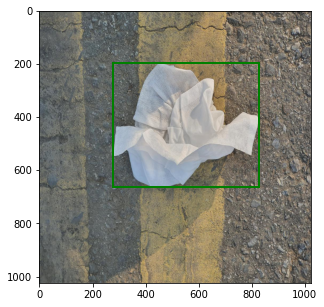

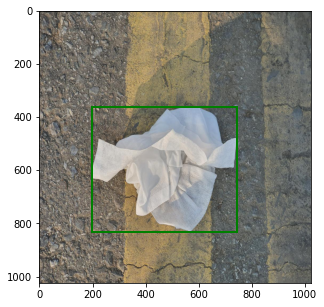

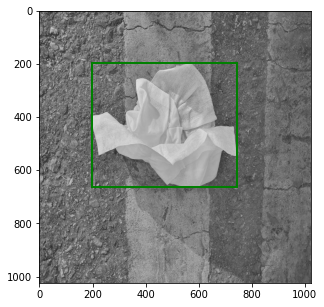

In [55]:
test_data = test_json['annotations'][23144:23147]
print(test_data)
for data,img in zip(test_data,test_list):
    x1,y1,w,h = data['bbox']
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    plt.imshow(img)
    test_b = patches.Rectangle((x1, y1),w,h,linewidth=2,edgecolor = 'green',fill=False)
    ax.add_patch(test_b)
    plt.show()
